In [15]:
from tqdm.auto import tqdm
import numba as numba
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [25]:
# class CustomLSTMCell(layers.Layer):

#     def __init__(self, units, **kwargs):
#         self.units = units
#         self.state_size = [units, units, units]  # Added third state
#         super(CustomLSTMCell, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.kernel = self.add_weight(shape=(input_shape[-1], self.units * 5),  # Changed from 4 to 5
#                                       initializer='glorot_uniform',
#                                       name='kernel')
#         self.recurrent_kernel = self.add_weight(
#             shape=(self.units, self.units * 5),  # Changed from 4 to 5
#             initializer='orthogonal',
#             name='recurrent_kernel')
#         self.bias = self.add_weight(shape=(self.units * 5,),  # Changed from 4 to 5
#                                     initializer='zeros',
#                                     name='bias')

#     def call(self, inputs, states):
#         h_tm1 = states[0]  # previous memory state
#         c_tm1 = states[1]  # previous carry state
#         l_tm1 = states[2]  # new long-term state

#         z = tf.matmul(inputs, self.kernel) + tf.matmul(h_tm1, self.recurrent_kernel) + self.bias

#         z0, z1, z2, z3, z4 = tf.split(z, 5, axis=-1)  # Changed from 4 to 5

#         f = tf.nn.sigmoid(z0)
#         i = tf.nn.sigmoid(z1 + 1.)
#         c = f * c_tm1 + i * tf.nn.tanh(z2)
#         o = tf.nn.sigmoid(z3)

#         l = l_tm1 + tf.nn.sigmoid(z4)  # Update the long-term state based on the new gate

#         h = o * tf.nn.tanh(c + l)  # Output depends on the long-term state as well as the cell state

#         return h, [h, c, l]  # Return the long-term state along with the other states
    
class CustomLSTMCell(layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = [units, units, units]
        super(CustomLSTMCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units * 5),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 5),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1]  # previous carry state
        l_tm1 = states[2]  # previous long-term state

        z = tf.matmul(inputs, self.kernel)
        z += tf.matmul(h_tm1, self.recurrent_kernel)
        z0, z1, z2, z3, z4 = tf.split(z, num_or_size_splits=5, axis=1)

        i = tf.nn.sigmoid(z0)
        f = tf.nn.sigmoid(z1)
        o = tf.nn.sigmoid(z2)
        z4 = tf.nn.tanh(z4)

        c = f * c_tm1 + i * tf.nn.tanh(z3)
        l = l_tm1 + c * z4  # update l using the current cell state as well
        h = o * tf.nn.tanh(c)

        return h, [h, c, l]



In [13]:
class CustomLSTMLayer(layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = [units, units]
        self.return_sequences = kwargs.pop('return_sequences', False)
        self.custom_lstm_cell = CustomLSTMCell(units)
        self.rnn_layer = layers.RNN(self.custom_lstm_cell, 
                                    return_sequences=self.return_sequences,
                                    **kwargs)
        super(CustomLSTMLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return self.rnn_layer(inputs)

In [4]:
# Load the IMDB dataset
num_words = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [5]:
def build_and_train_model(recurrent_layer, x_train, y_train, x_test, y_test):
    # Build the model
    model = Sequential([
        Embedding(num_words, 32),
        recurrent_layer,
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(
        x_train, 
        y_train, 
        epochs=25,
        use_multiprocessing=True,
        batch_size=32,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping]
    )

    # Return the history object for later comparison
    return history

In [6]:
# Train a model with a standard LSTM layer
lstm_history = build_and_train_model(LSTM(100), x_train, y_train, x_test, y_test)  

2023-06-30 14:25:21.794646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 14:25:21.869096: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-30 14:25:22.067038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

Epoch 1/25


2023-06-30 14:25:22.377107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 14:25:22.378762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 14:25:22.379657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.7839

2023-06-30 14:27:36.135236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 14:27:36.136611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 14:27:36.137575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 169s 214ms/step - loss: 0.4481 - accuracy: 0.7839 - val_loss: 0.3700 - val_accuracy: 0.8423
Epoch 2/25
782/782 [==============================] - 168s 215ms/step - loss: 0.3750 - accuracy: 0.8431 - val_loss: 0.3717 - val_accuracy: 0.8386
Epoch 3/25
782/782 [==============================] - 174s 222ms/step - loss: 0.2367 - accuracy: 0.9095 - val_loss: 0.3573 - val_accuracy: 0.8516
Epoch 4/25
782/782 [==============================] - 173s 221ms/step - loss: 0.1886 - accuracy: 0.9296 - val_loss: 0.3405 - val_accuracy: 0.8705
Epoch 5/25
782/782 [==============================] - 176s 225ms/step - loss: 0.1602 - accuracy: 0.9409 - val_loss: 0.3651 - val_accuracy: 0.8666
Epoch 6/25
782/782 [==============================] - 173s 221ms/step - loss: 0.1114 - accuracy: 0.9619 - val_loss: 0.4333 - val_accuracy: 0.8531
Epoch 7/25
782/782 [==============================] - 184s 236ms/step - loss: 0.0884 - accuracy: 0.9701 - val_loss: 0.5876 - val_accura

In [ ]:
# Train a model with a custom LSTM layer
custom_lstm_history = build_and_train_model(CustomLSTMLayer(100), x_train, y_train, x_test, y_test)

Epoch 1/25
782/782 [==============================] - 183s 233ms/step - loss: 0.4960 - accuracy: 0.7663 - val_loss: 0.4424 - val_accuracy: 0.8317
Epoch 2/25
782/782 [==============================] - 192s 246ms/step - loss: 0.4150 - accuracy: 0.8073 - val_loss: 0.5259 - val_accuracy: 0.7333
Epoch 3/25
782/782 [==============================] - 190s 243ms/step - loss: 0.5127 - accuracy: 0.7456 - val_loss: 1.0014 - val_accuracy: 0.5411
Epoch 4/25
782/782 [==============================] - 190s 243ms/step - loss: 0.3164 - accuracy: 0.8689 - val_loss: 0.3467 - val_accuracy: 0.8684
Epoch 5/25
782/782 [==============================] - 187s 240ms/step - loss: 0.2301 - accuracy: 0.9119 - val_loss: 0.3405 - val_accuracy: 0.8652
Epoch 6/25
548/782 [====================>.........] - ETA: 41s - loss: 0.1752 - accuracy: 0.9336

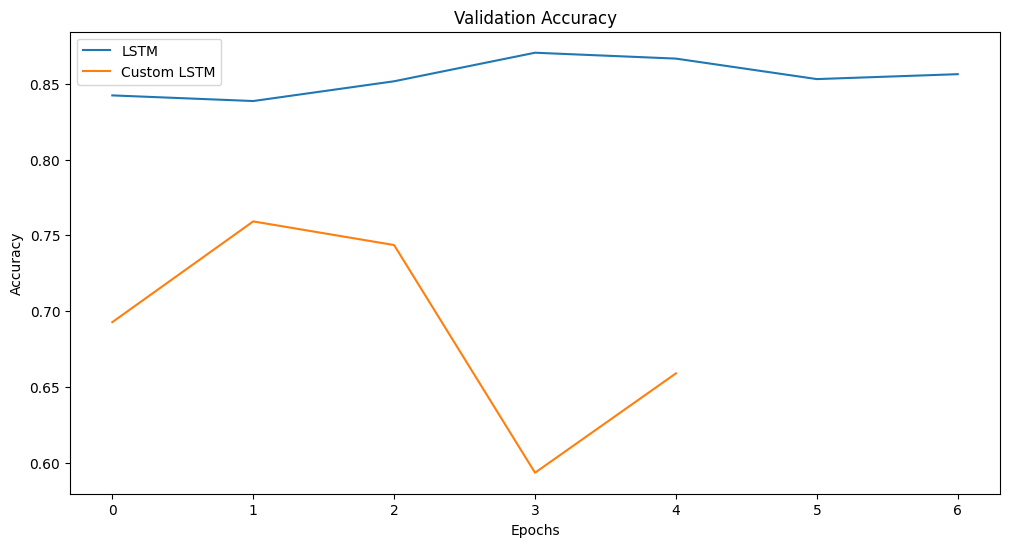

In [10]:
import matplotlib.pyplot as plt

# Plot the validation accuracy of both models
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['val_accuracy'], label='LSTM')
plt.plot(custom_lstm_history.history['val_accuracy'], label='Custom LSTM')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()